<a href="https://colab.research.google.com/github/Ayatafoy/attention-based-cf/blob/main/Transformer_CF_movielens_20M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import itertools
from sklearn.metrics import mean_squared_error
tqdm.pandas()

#**Load movielens dataset**

In [ ]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-20m.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-20m.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-20m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = '/root/.keras/datasets/ml-20m/ratings.csv'

df = pd.read_csv(ratings_file)

# **Exploratory Data Analysis**


In [ ]:
df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [ ]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 138493, Number of Movies: 26744, Min Rating: 0.5, Max Rating: 5.0


In [ ]:
df = df[['user', 'movie', 'rating']]

In [ ]:
movie_counts = pd.DataFrame(df['user'].value_counts()).reset_index()
movie_counts.columns = ['user', 'num_movies']

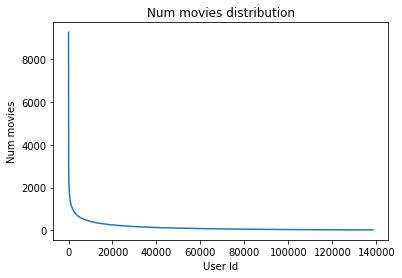

In [ ]:
plt.plot(range(len(df['user'].unique())), df['user'].value_counts().values)
plt.title('Num movies distribution')
plt.xlabel('User Id')
plt.ylabel('Num movies')
plt.show()

In [ ]:
num_movies_distribution = []
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 512]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 256]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 128]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 64]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 32]) / num_users * 100)

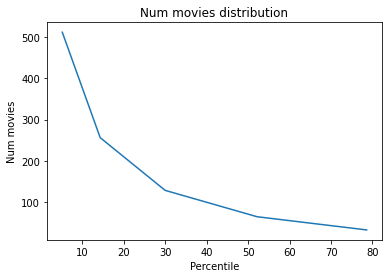

In [ ]:
plt.plot(
    [
        num_movies_distribution[4], 
        num_movies_distribution[3],
        num_movies_distribution[2], 
        num_movies_distribution[1], 
        num_movies_distribution[0]
    ], 
    [32, 64, 128, 256, 512]
)
plt.title('Num movies distribution')
plt.xlabel('Percentile')
plt.ylabel('Num movies')
plt.show()

In [ ]:
user_counts = pd.DataFrame(df['movie'].value_counts()).reset_index()
user_counts.columns = ['movie', 'num_users']

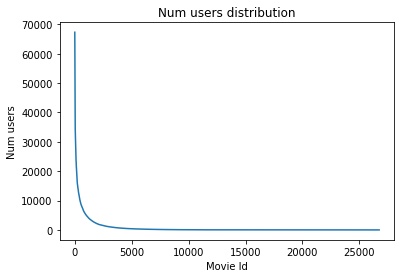

In [ ]:
plt.plot(range(len(df['movie'].unique())), df['movie'].value_counts().values)
plt.title('Num users distribution')
plt.xlabel('Movie Id')
plt.ylabel('Num users')
plt.show()

In [ ]:
num_users_distribution = []
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 2048]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 1024]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 512]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 256]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 128]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 64]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 32]) / num_movies * 100)

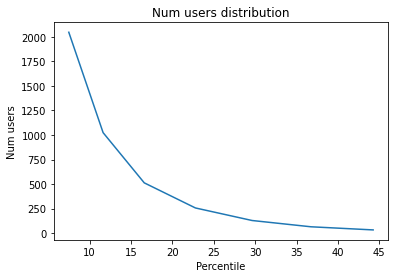

In [ ]:
plt.plot(
    [
        num_users_distribution[6],
        num_users_distribution[5],
        num_users_distribution[4], 
        num_users_distribution[3],
        num_users_distribution[2], 
        num_users_distribution[1], 
        num_users_distribution[0]
    ], 
    [32, 64, 128, 256, 512, 1024, 2048]
)
plt.title('Num users distribution')
plt.xlabel('Percentile')
plt.ylabel('Num users')
plt.show()

In [ ]:
print(f'Sparsity:{1 - len(df) / (num_users * num_movies)}')

Sparsity:0.9946001521864456


## **Dataset preparation**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
ratings_arr = np.array(df['rating']).reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaler.fit(ratings_arr)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
df['rating'] = target_scaler.transform(ratings_arr)
data_train, data_test = train_test_split(df, test_size=0.1, random_state=42)
data_test = data_test[data_test['user'].isin(data_train['user'])]
data_test = data_test[data_test['movie'].isin(data_train['movie'])]

In [ ]:
hot_movies_counts = movie_counts[movie_counts['num_movies'] >= 50]
cold_movies_counts = movie_counts[movie_counts['num_movies'] < 50]

hot_users_counts = user_counts[user_counts['num_users'] >= 50]
cold_users_counts = user_counts[user_counts['num_users'] < 50]

In [ ]:
hot_user_data_test = data_test[data_test['user'].isin(hot_movies_counts['user'])]
cold_user_data_test = data_test[data_test['user'].isin(cold_movies_counts['user'])]

hot_movie_data_test = data_test[data_test['movie'].isin(hot_users_counts['movie'])]
cold_movie_data_test = data_test[data_test['movie'].isin(cold_users_counts['movie'])]

#**Error metric definition**

In [ ]:
def print_bold(text):
    print('\033[1m' + text)

In [ ]:
def calculate_error(predictions, y_true):
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = target_scaler.inverse_transform(predictions)
    y_true_arr = np.array(y_true).reshape(-1, 1)
    y_true = target_scaler.inverse_transform(y_true_arr)

    mse = mean_squared_error(y_true, predictions, squared=True)
    print(f'MSE score: {mse}')

    rmse = mean_squared_error(y_true, predictions, squared=False)
    print(f'RMSE score: {rmse}\n')

    return rmse

#**Matrix factorization using Alternative Least Squares**

###Read ALS dataset

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 4.3MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419446 sha256=7cdd6101d78598510bc9fd1b9fa6f809794632e6a7f6ec0ac5c1525e673c6954
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
from scipy.sparse import csr_matrix
import implicit

In [ ]:
sparse_item_user = csr_matrix((data_train['rating'].astype(float), (data_train['movie'], data_train['user'])))
sparse_user_item = csr_matrix((data_train['rating'].astype(float), (data_train['user'], data_train['movie'])))

###ALS random search tuning

In [ ]:
def predict_als_rating(user_embeddings, item_embeddings, u, i):
    return np.dot(user_embeddings[u, :], item_embeddings[i, :])

def predict_als(user_embdeddings, movie_embeddings, data_test):
  predictions = []
  for pair in data_test.itertuples():
      prediction = predict_als_rating(user_embdeddings, movie_embeddings, pair.user, pair.movie)
      predictions.append(prediction)

  return predictions

def sample_hyperparameters():
    while True:
        yield {
            "regularization": np.random.exponential(0.05),
            "factors": np.random.randint(5, 300),
            "iterations": np.random.randint(1, 50),
            "use_gpu": True, 
            "num_threads": 2,
            "alpha_val": np.random.randint(1, 100),
        }

def random_search(sparse_item_user, data_test, num_samples=100):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams)
        alpha_val = hyperparams.pop("alpha_val")

        model = implicit.als.AlternatingLeastSquares(**hyperparams)
        data_conf = (sparse_item_user * alpha_val).astype('double')
        model.fit(data_conf)

        user_embeddings = model.user_factors
        item_embeddings = model.item_factors

        predictions =  predict_als(user_embeddings, item_embeddings, data_test)
        score = calculate_error(predictions, data_test['rating'])

        yield (score, hyperparams, model)

In [ ]:
(score, hyperparams, model) = min(random_search(sparse_item_user, data_test), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

GPU training requires factor size to be a multiple of 32. Increasing factors from 195 to 224.


{'regularization': 0.07483860149154246, 'factors': 195, 'iterations': 47, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 99}


MSE score: 2.9777848720550537
RMSE score: 1.725625991821289

{'regularization': 0.12106075463957336, 'factors': 55, 'iterations': 3, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 12}


MSE score: 1.9443333148956299
RMSE score: 1.3943935632705688

{'regularization': 0.03129766814165232, 'factors': 19, 'iterations': 39, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 42}


MSE score: 2.11613392829895
RMSE score: 1.4546937942504883

{'regularization': 0.030993583900373003, 'factors': 226, 'iterations': 20, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 28}


MSE score: 2.972738265991211
RMSE score: 1.7241630554199219

{'regularization': 0.014164900244206023, 'factors': 271, 'iterations': 16, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 30}


MSE score: 3.1065218448638916
RMSE score: 1.7625328302383423

{'regularization': 0.13322345545967626, 'factors': 219, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 74}


MSE score: 2.545125722885132
RMSE score: 1.5953450202941895

{'regularization': 0.06871539804600266, 'factors': 191, 'iterations': 3, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}


MSE score: 2.1910033226013184
RMSE score: 1.4802038669586182

{'regularization': 0.030865033205799277, 'factors': 150, 'iterations': 41, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 21}


MSE score: 2.4835588932037354
RMSE score: 1.5759310722351074

{'regularization': 0.0036777996071716344, 'factors': 223, 'iterations': 13, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}


MSE score: 2.780703067779541
RMSE score: 1.6675440073013306

{'regularization': 0.037508996432319655, 'factors': 178, 'iterations': 39, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}


MSE score: 5.067080974578857
RMSE score: 2.2510178089141846

{'regularization': 0.04542200011015343, 'factors': 29, 'iterations': 12, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 91}


MSE score: 2.3681936264038086
RMSE score: 1.5388935804367065

{'regularization': 0.021341381607730046, 'factors': 223, 'iterations': 47, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 28}


MSE score: 2.9626519680023193
RMSE score: 1.7212356328964233

{'regularization': 0.2107438222860486, 'factors': 174, 'iterations': 18, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 83}


MSE score: 2.5997955799102783
RMSE score: 1.6123881340026855

{'regularization': 0.16523262918066808, 'factors': 97, 'iterations': 24, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 7}


MSE score: 2.367961883544922
RMSE score: 1.538818359375

{'regularization': 0.0005035017202264702, 'factors': 141, 'iterations': 21, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}


MSE score: 2.702009916305542
RMSE score: 1.6437791585922241

{'regularization': 0.09917069358989122, 'factors': 113, 'iterations': 16, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 27}


MSE score: 2.2860941886901855
RMSE score: 1.5119835138320923

{'regularization': 0.05340434723931997, 'factors': 273, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 37}


MSE score: 2.5229880809783936
RMSE score: 1.588391661643982

{'regularization': 0.12426776223830703, 'factors': 191, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 88}


MSE score: 2.444411516189575
RMSE score: 1.563461422920227

{'regularization': 0.03616760631270841, 'factors': 254, 'iterations': 37, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 72}


MSE score: 3.091104030609131
RMSE score: 1.7581535577774048

{'regularization': 0.07034679450120501, 'factors': 77, 'iterations': 27, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 16}


MSE score: 2.1083908081054688
RMSE score: 1.4520299434661865

{'regularization': 0.040745820613810574, 'factors': 270, 'iterations': 34, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 31}


MSE score: 3.3324689865112305
RMSE score: 1.8255051374435425

{'regularization': 0.005383973769518556, 'factors': 17, 'iterations': 30, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 93}


MSE score: 2.3835136890411377
RMSE score: 1.5438631772994995

{'regularization': 0.011639454800693352, 'factors': 97, 'iterations': 38, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 96}


MSE score: 2.6051812171936035
RMSE score: 1.6140574216842651

{'regularization': 0.09335244916256245, 'factors': 213, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 26}


MSE score: 2.88581919670105
RMSE score: 1.6987699270248413

{'regularization': 0.00891475334693498, 'factors': 261, 'iterations': 20, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 68}


MSE score: 3.121873140335083
RMSE score: 1.766882300376892

{'regularization': 0.016727513018956794, 'factors': 7, 'iterations': 1, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 69}


MSE score: 2.1217620372772217
RMSE score: 1.4566268920898438

{'regularization': 0.003044080808435409, 'factors': 13, 'iterations': 41, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 22}


MSE score: 1.938752293586731
RMSE score: 1.3923908472061157

{'regularization': 0.07330064462371508, 'factors': 158, 'iterations': 21, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 32}


MSE score: 2.4423136711120605
RMSE score: 1.5627903938293457

{'regularization': 0.03139454557299627, 'factors': 239, 'iterations': 2, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 27}


MSE score: 2.204854965209961
RMSE score: 1.4848754405975342

{'regularization': 0.084829515307367, 'factors': 131, 'iterations': 2, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 90}


MSE score: 2.1486778259277344
RMSE score: 1.4658368825912476

{'regularization': 0.10294549117875594, 'factors': 252, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 89}


MSE score: 2.6096818447113037
RMSE score: 1.6154509782791138

{'regularization': 0.011954986549610188, 'factors': 38, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 64}


MSE score: 2.3373188972473145
RMSE score: 1.5288292169570923

{'regularization': 0.06464614224410256, 'factors': 170, 'iterations': 5, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 2}


MSE score: 3.8421666622161865
RMSE score: 1.9601445198059082

{'regularization': 0.05374844797015665, 'factors': 227, 'iterations': 45, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 67}


MSE score: 3.1537163257598877
RMSE score: 1.7758705615997314

{'regularization': 0.009930892660628212, 'factors': 231, 'iterations': 25, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 23}


MSE score: 3.114223003387451
RMSE score: 1.7647161483764648

{'regularization': 0.03715255529795502, 'factors': 257, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 60}


MSE score: 3.330622673034668
RMSE score: 1.8249993324279785

{'regularization': 0.07083306574142652, 'factors': 99, 'iterations': 29, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 92}


MSE score: 2.561206817626953
RMSE score: 1.600377082824707

{'regularization': 0.04693904790711295, 'factors': 235, 'iterations': 24, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 85}


MSE score: 2.9166860580444336
RMSE score: 1.707830786705017

{'regularization': 0.028033608942980223, 'factors': 168, 'iterations': 30, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 59}


MSE score: 2.705998420715332
RMSE score: 1.6449918746948242

{'regularization': 0.09148104870853116, 'factors': 143, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 55}


MSE score: 2.4351844787597656
RMSE score: 1.5605077743530273

{'regularization': 0.23606515112676504, 'factors': 10, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 45}


MSE score: 2.1237540245056152
RMSE score: 1.4573105573654175

{'regularization': 0.020871805438419933, 'factors': 51, 'iterations': 42, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 96}


MSE score: 2.4606282711029053
RMSE score: 1.5686390399932861

{'regularization': 0.017144577850818864, 'factors': 92, 'iterations': 17, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 47}


MSE score: 2.3211400508880615
RMSE score: 1.523528814315796

{'regularization': 0.18929547306712705, 'factors': 179, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 95}


MSE score: 2.740248680114746
RMSE score: 1.6553696393966675

{'regularization': 0.01665252879642474, 'factors': 159, 'iterations': 22, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 50}


MSE score: 2.5414023399353027
RMSE score: 1.5941776037216187

{'regularization': 0.005799289905684738, 'factors': 6, 'iterations': 3, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 22}


MSE score: 1.9130101203918457
RMSE score: 1.3831161260604858

{'regularization': 0.008421379715263532, 'factors': 260, 'iterations': 25, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 88}


MSE score: 3.1708719730377197
RMSE score: 1.7806942462921143

{'regularization': 0.0007661149557220893, 'factors': 207, 'iterations': 2, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 89}


MSE score: 2.521552801132202
RMSE score: 1.587939739227295

{'regularization': 0.004714039606399108, 'factors': 110, 'iterations': 12, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 16}


MSE score: 2.255859851837158
RMSE score: 1.501952052116394

{'regularization': 0.017119903602484398, 'factors': 251, 'iterations': 2, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}


MSE score: 4.466884613037109
RMSE score: 2.1135005950927734

{'regularization': 0.005502126676257411, 'factors': 131, 'iterations': 28, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 75}


MSE score: 2.6657614707946777
RMSE score: 1.6327159404754639

{'regularization': 0.009858517115842312, 'factors': 273, 'iterations': 25, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 8}


MSE score: 3.754401445388794
RMSE score: 1.9376277923583984

{'regularization': 0.004623964783569041, 'factors': 209, 'iterations': 39, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 7}


MSE score: 3.2948522567749023
RMSE score: 1.815172791481018

{'regularization': 0.07856287251750546, 'factors': 270, 'iterations': 17, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 12}


MSE score: 3.363406181335449
RMSE score: 1.8339591026306152

{'regularization': 0.02043280518140861, 'factors': 8, 'iterations': 5, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 8}


MSE score: 1.898706078529358
RMSE score: 1.3779354095458984

{'regularization': 0.039274202847626574, 'factors': 152, 'iterations': 46, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 74}


MSE score: 2.6783318519592285
RMSE score: 1.6365610361099243

{'regularization': 0.019951337325658194, 'factors': 298, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 48}


MSE score: 3.6152842044830322
RMSE score: 1.9013900756835938

{'regularization': 0.0928661063747148, 'factors': 170, 'iterations': 10, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 86}


MSE score: 2.505544662475586
RMSE score: 1.5828912258148193

{'regularization': 0.011134088141417782, 'factors': 7, 'iterations': 4, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 58}


MSE score: 2.177222728729248
RMSE score: 1.4755414724349976

{'regularization': 0.07216952386275609, 'factors': 88, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 69}


MSE score: 2.442596197128296
RMSE score: 1.5628807544708252

{'regularization': 0.029979804982115655, 'factors': 39, 'iterations': 40, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}


MSE score: 3.786750555038452
RMSE score: 1.9459575414657593

{'regularization': 0.02193307431037407, 'factors': 12, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 82}


MSE score: 2.3312630653381348
RMSE score: 1.5268474817276

{'regularization': 0.0708501211677962, 'factors': 152, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 8}


MSE score: 2.421572208404541
RMSE score: 1.5561401844024658

{'regularization': 0.008539036941361862, 'factors': 145, 'iterations': 38, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 66}


MSE score: 2.6541919708251953
RMSE score: 1.6291691064834595

{'regularization': 0.01897224752748572, 'factors': 199, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 5}


MSE score: 3.519217014312744
RMSE score: 1.8759576082229614

{'regularization': 0.007675899882243227, 'factors': 174, 'iterations': 40, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 42}


MSE score: 2.761500358581543
RMSE score: 1.6617763042449951

{'regularization': 0.03037741679263914, 'factors': 49, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 37}


MSE score: 2.177490234375
RMSE score: 1.4756321907043457

{'regularization': 0.086240011676816, 'factors': 183, 'iterations': 29, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 54}


MSE score: 2.66755747795105
RMSE score: 1.6332658529281616

{'regularization': 3.306135801357813e-05, 'factors': 79, 'iterations': 2, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 2}


MSE score: 3.0586700439453125
RMSE score: 1.7489054203033447

{'regularization': 0.06202602153382767, 'factors': 166, 'iterations': 15, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 31}


MSE score: 2.531848669052124
RMSE score: 1.5911784172058105

{'regularization': 0.04081425503205103, 'factors': 28, 'iterations': 48, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 10}


MSE score: 1.8613849878311157
RMSE score: 1.3643258810043335

{'regularization': 0.09844308996397765, 'factors': 163, 'iterations': 12, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 54}


MSE score: 2.512694835662842
RMSE score: 1.5851482152938843

{'regularization': 0.03956634671369009, 'factors': 158, 'iterations': 23, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 89}


MSE score: 2.6158692836761475
RMSE score: 1.6173648834228516

{'regularization': 0.10349553017222413, 'factors': 166, 'iterations': 9, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 37}


MSE score: 2.4236838817596436
RMSE score: 1.5568184852600098

{'regularization': 0.13553089383738207, 'factors': 65, 'iterations': 14, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 7}


MSE score: 2.1490321159362793
RMSE score: 1.465957760810852

{'regularization': 0.004432572447125026, 'factors': 11, 'iterations': 45, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 92}


MSE score: 2.377516746520996
RMSE score: 1.5419198274612427

{'regularization': 0.10273093813250278, 'factors': 63, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 21}


MSE score: 2.0107979774475098
RMSE score: 1.418026089668274

{'regularization': 0.011399670766538974, 'factors': 210, 'iterations': 23, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 35}



MSE score: 2.8652567863464355
RMSE score: 1.6927069425582886

{'regularization': 0.015603304583017253, 'factors': 128, 'iterations': 17, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}


MSE score: 2.4482433795928955
RMSE score: 1.5646862983703613

{'regularization': 0.03314140253573055, 'factors': 217, 'iterations': 12, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 52}


MSE score: 2.6292572021484375
RMSE score: 1.621498465538025

{'regularization': 0.036956632699878554, 'factors': 270, 'iterations': 4, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 12}


MSE score: 2.675356149673462
RMSE score: 1.6356515884399414

{'regularization': 0.010134318595555792, 'factors': 159, 'iterations': 21, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}


MSE score: 4.740689754486084
RMSE score: 2.1773126125335693

{'regularization': 0.08865098645520997, 'factors': 97, 'iterations': 1, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 79}


MSE score: 2.05786395072937
RMSE score: 1.434525728225708

{'regularization': 0.10057776905983484, 'factors': 298, 'iterations': 32, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 91}


MSE score: 3.23095440864563
RMSE score: 1.797485589981079

{'regularization': 0.018209176795463064, 'factors': 240, 'iterations': 23, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 38}


MSE score: 3.013885259628296
RMSE score: 1.736054539680481

{'regularization': 0.01800661183435531, 'factors': 201, 'iterations': 16, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 22}


MSE score: 2.7560994625091553
RMSE score: 1.660150408744812

{'regularization': 0.013279746056703866, 'factors': 246, 'iterations': 5, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 17}


MSE score: 2.598759174346924
RMSE score: 1.6120667457580566

{'regularization': 0.04698141469850273, 'factors': 130, 'iterations': 9, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 37}


MSE score: 2.363407850265503
RMSE score: 1.5373378992080688

{'regularization': 0.005608704728198316, 'factors': 75, 'iterations': 48, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 24}



MSE score: 2.186171531677246
RMSE score: 1.478570818901062

{'regularization': 0.037482626250238175, 'factors': 96, 'iterations': 9, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 41}


MSE score: 2.2415027618408203
RMSE score: 1.4971649646759033

{'regularization': 0.009431653798612438, 'factors': 123, 'iterations': 38, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 21}


MSE score: 2.3082070350646973
RMSE score: 1.5192784070968628

{'regularization': 0.036628136436785634, 'factors': 204, 'iterations': 23, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 8}


MSE score: 3.126677989959717
RMSE score: 1.76824152469635

{'regularization': 0.08752171243158967, 'factors': 157, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 2}


MSE score: 3.7920780181884766
RMSE score: 1.9473258256912231

{'regularization': 0.01582063780106391, 'factors': 227, 'iterations': 30, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 29}


MSE score: 3.117570400238037
RMSE score: 1.7656643390655518

{'regularization': 0.16017835400663352, 'factors': 185, 'iterations': 2, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 61}


MSE score: 2.080766201019287
RMSE score: 1.4424861669540405

{'regularization': 0.020984632980315512, 'factors': 257, 'iterations': 9, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 63}


MSE score: 2.7141618728637695
RMSE score: 1.647471308708191

{'regularization': 0.006812647253272375, 'factors': 250, 'iterations': 33, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 22}


MSE score: 3.223721742630005
RMSE score: 1.7954726219177246

{'regularization': 0.0789606225679521, 'factors': 265, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}


MSE score: 5.729633331298828
RMSE score: 2.393665313720703

{'regularization': 0.06877059706757692, 'factors': 179, 'iterations': 7, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 83}


MSE score: 2.429311752319336
RMSE score: 1.5586249828338623

{'regularization': 0.0018466286633208621, 'factors': 29, 'iterations': 22, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}



MSE score: 2.3205137252807617
RMSE score: 1.5233232975006104

Best score 1.3643258810043335 at {'regularization': 0.04081425503205103, 'factors': 28, 'iterations': 48, 'use_gpu': True, 'num_threads': 2}


###ALS fitting best params

In [ ]:
params = {
    'regularization': 0.04081425503205103,
    'factors': 28,
    'iterations': 48, 
    'use_gpu': True, 
    'num_threads': 2
}

In [ ]:
#Building the model
model = implicit.als.AlternatingLeastSquares(**params)
alpha_val = 10
data_conf = (sparse_item_user * alpha_val).astype('double')
model.fit(data_conf)

user_embeddings = model.user_factors
item_embeddings = model.item_factors

###ALS evaluation

In [ ]:
print_bold('Global Error:')
predictions = predict_als(user_embeddings, item_embeddings, data_test)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
predictions = predict_als(user_embeddings, item_embeddings, hot_user_data_test)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
predictions = predict_als(user_embeddings, item_embeddings, cold_user_data_test)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
predictions = predict_als(user_embeddings, item_embeddings, hot_movie_data_test)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
predictions = predict_als(user_embeddings, item_embeddings, cold_movie_data_test)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 1.8608185052871704
RMSE score: 1.364118218421936

Only hot users error:
MSE score: 1.7968227863311768
RMSE score: 1.3404561281204224

Only cold users error:
MSE score: 2.9193785190582275
RMSE score: 1.7086188793182373

Only hot movies error:
MSE score: 1.8272331953048706
RMSE score: 1.3517519235610962

Only cold movies error:
MSE score: 3.3067808151245117
RMSE score: 1.8184555768966675



1.8184556

# **Matrix factorization using LightFM**

###Read LightFM dataset

In [ ]:
!pip install lightfm

     |████████████████████████████████| 317kB 5.9MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp36-cp36m-linux_x86_64.whl size=704256 sha256=796081cfa49a0518ef95e80ed71309741b11a9107b0820323a1425feb2187ace
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [ ]:
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from scipy.sparse import coo_matrix
from lightfm import LightFM

In [ ]:
def convert_df_to_coo(df):
    row = df['user']
    col = df['movie']
    data = df['rating']
    row_count = max(row) + 1
    col_count = max(col) + 1
    coo = coo_matrix((data, (row, col)), shape=(row_count, col_count))

    return coo

In [ ]:
train_data_coo = convert_df_to_coo(data_train)
test_data_coo = convert_df_to_coo(data_test)

###LightFM random search tuning

In [ ]:
import itertools
import numpy as np
from lightfm import LightFM


def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(1, 5),
        }


def random_search(train, data_test, num_samples=100, num_threads=2):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams)
        num_epochs = hyperparams.pop("num_epochs")
        print(f'Num epochs: {num_epochs}')
        
        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads, verbose=True)

        test_users = np.array(data_test['user'])
        test_movies = np.array(data_test['movie'])
        predictions = model.predict(test_users, test_movies, num_threads=2).reshape(-1, 1)
        score = calculate_error(predictions, data_test['rating'])

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [ ]:
from lightfm.datasets import fetch_movielens

(score, hyperparams, model) = min(random_search(train_data_coo, data_test, num_threads=2), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

{'no_components': 49, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.04284433481909922, 'item_alpha': 5.291739772154591e-10, 'user_alpha': 1.0766742721033665e-08, 'max_sampled': 10, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 163.88987731933594
RMSE score: 12.801948547363281

{'no_components': 43, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.016109690096925346, 'item_alpha': 5.645276054294475e-09, 'user_alpha': 3.57416279827423e-08, 'max_sampled': 8, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 35.19022750854492
RMSE score: 5.932135105133057

{'no_components': 43, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.09865718579232549, 'item_alpha': 2.2814130331002374e-08, 'user_alpha': 6.066717841377205e-09, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 266.22650146484375
RMSE score: 16.316448211669922

{'no_components': 26, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0376448803431316, 'item_alpha': 4.801730453850725e-09, 'user_alpha': 7.203374419830283e-09, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 31.992244720458984
RMSE score: 5.6561689376831055

{'no_components': 42, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.005117717711177088, 'item_alpha': 5.2716932675426825e-09, 'user_alpha': 3.742009943730572e-09, 'max_sampled': 13, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 396.4450378417969
RMSE score: 19.910926818847656

{'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.03160502226271621, 'item_alpha': 2.225463437945744e-09, 'user_alpha': 1.1452319834590134e-10, 'max_sampled': 7, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 39.5734748840332
RMSE score: 6.290745258331299

{'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.003613048397235258, 'item_alpha': 1.0263303396797826e-07, 'user_alpha': 3.055941191279445e-08, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 9.886185646057129
RMSE score: 3.144230604171753

{'no_components': 52, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.08813356880895146, 'item_alpha': 2.9213345793615093e-10, 'user_alpha': 2.4512430631603702e-08, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 238.9940185546875
RMSE score: 15.459431648254395

{'no_components': 59, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.04621643977245152, 'item_alpha': 1.776922868310811e-08, 'user_alpha': 1.359403104502116e-09, 'max_sampled': 7, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 74.9031753540039
RMSE score: 8.654662132263184

{'no_components': 48, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.015929988242180528, 'item_alpha': 2.399305609844754e-08, 'user_alpha': 1.608760074475829e-08, 'max_sampled': 12, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 57.17766571044922
RMSE score: 7.561591625213623

{'no_components': 43, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.010163459874863745, 'item_alpha': 3.255690150648746e-08, 'user_alpha': 1.6397680132338687e-10, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 26.958423614501953
RMSE score: 5.192150115966797

{'no_components': 16, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0991618518659474, 'item_alpha': 2.2828582920704582e-08, 'user_alpha': 5.808028251673878e-09, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 179.20297241210938
RMSE score: 13.38667106628418

{'no_components': 52, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.006050948076956769, 'item_alpha': 3.225568052216211e-09, 'user_alpha': 4.523296696643284e-09, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 11.491515159606934
RMSE score: 3.38991379737854

{'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.02207632716706503, 'item_alpha': 3.2580885292116734e-09, 'user_alpha': 2.0034041445149797e-08, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 42.4578971862793
RMSE score: 6.51597261428833

{'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.009168069939610756, 'item_alpha': 1.102504140487224e-08, 'user_alpha': 1.7909849523176425e-09, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 286.9837646484375
RMSE score: 16.940595626831055

{'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.04898756525849537, 'item_alpha': 1.9998943583202962e-09, 'user_alpha': 1.2027688338374252e-08, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 130.8539276123047
RMSE score: 11.439140319824219

{'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.06927241880673801, 'item_alpha': 8.253376676006867e-10, 'user_alpha': 1.6120233272067416e-08, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 96.03402709960938
RMSE score: 9.799695014953613

{'no_components': 28, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.020625690388655117, 'item_alpha': 1.8430521212322474e-08, 'user_alpha': 5.462612848771288e-09, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 716.0115356445312
RMSE score: 26.758392333984375

{'no_components': 50, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.1733297622600328, 'item_alpha': 5.2132167169630496e-09, 'user_alpha': 8.523702780489177e-09, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 335.53741455078125
RMSE score: 18.31768035888672

{'no_components': 60, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.07667063636959111, 'item_alpha': 1.2471750482470413e-10, 'user_alpha': 1.2493790346671084e-08, 'max_sampled': 9, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 209.8404998779297
RMSE score: 14.485872268676758

{'no_components': 62, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.31569278347742347, 'item_alpha': 1.1465037010649182e-08, 'user_alpha': 7.070198771077114e-09, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 40348454912.0
RMSE score: 200869.25

{'no_components': 29, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.03167516857662122, 'item_alpha': 9.856223676385801e-09, 'user_alpha': 4.398291720780967e-09, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 52.00688552856445
RMSE score: 7.2115797996521

{'no_components': 38, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.07943127798595379, 'item_alpha': 8.848350083869627e-09, 'user_alpha': 3.505700092700113e-08, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 271.4815673828125
RMSE score: 16.47669792175293

{'no_components': 48, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.1372387217976721, 'item_alpha': 8.982400024467489e-10, 'user_alpha': 2.468802951534454e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 509.1143493652344
RMSE score: 22.563562393188477

{'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.011004153211723154, 'item_alpha': 1.779719718666812e-08, 'user_alpha': 2.583818495517767e-08, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 22.31393814086914
RMSE score: 4.7237629890441895

{'no_components': 62, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.007933366891835145, 'item_alpha': 2.6527491078621798e-08, 'user_alpha': 2.4127780854253667e-08, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 20.95245933532715
RMSE score: 4.577385425567627

{'no_components': 61, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.02568711045483407, 'item_alpha': 3.853808113430906e-08, 'user_alpha': 1.041763825941461e-08, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 40.74306106567383
RMSE score: 6.383028984069824

{'no_components': 17, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.177325538048952, 'item_alpha': 3.214390383229776e-10, 'user_alpha': 2.040251258318125e-09, 'max_sampled': 7, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 508.36651611328125
RMSE score: 22.54698371887207

{'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.013381659505031574, 'item_alpha': 8.507958431796319e-09, 'user_alpha': 1.0766202161914853e-08, 'max_sampled': 9, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 21.9973201751709
RMSE score: 4.690130233764648

{'no_components': 50, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.01955205103872193, 'item_alpha': 5.437071865705497e-09, 'user_alpha': 7.094408110485327e-09, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 340.5545349121094
RMSE score: 18.454120635986328

{'no_components': 62, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.06926017585807485, 'item_alpha': 1.52814189761124e-08, 'user_alpha': 3.5716082136438194e-09, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 56.43855667114258
RMSE score: 7.51255989074707

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.06147861603704333, 'item_alpha': 5.3882978345643795e-09, 'user_alpha': 1.6438309612898096e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 374.7763366699219
RMSE score: 19.359140396118164

{'no_components': 21, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.06494412658413028, 'item_alpha': 8.181159970889122e-09, 'user_alpha': 9.31489787357493e-09, 'max_sampled': 12, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 219.0282745361328
RMSE score: 14.799603462219238

{'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.02489386826525684, 'item_alpha': 1.561729141711485e-08, 'user_alpha': 2.453213298066347e-10, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 1116.6405029296875
RMSE score: 33.41617202758789

{'no_components': 34, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.08954856505556177, 'item_alpha': 2.825616489010877e-08, 'user_alpha': 6.197734716381568e-09, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 154.1495819091797
RMSE score: 12.415699005126953

{'no_components': 53, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.004027910741261456, 'item_alpha': 2.4162282735782653e-08, 'user_alpha': 1.239275125163194e-09, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 182.36976623535156
RMSE score: 13.504434585571289

{'no_components': 60, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.06569967944368167, 'item_alpha': 1.526829239416592e-08, 'user_alpha': 5.1702112069524485e-09, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 228.78704833984375
RMSE score: 15.12570858001709

{'no_components': 33, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.009025491600476465, 'item_alpha': 1.1068746824808882e-08, 'user_alpha': 8.352344486256263e-10, 'max_sampled': 11, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 21.78131103515625
RMSE score: 4.6670451164245605

{'no_components': 27, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.023626624983159098, 'item_alpha': 1.4349052445554191e-08, 'user_alpha': 1.3724908396025044e-08, 'max_sampled': 6, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 63.23085403442383
RMSE score: 7.951783180236816

{'no_components': 32, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.01746837465516698, 'item_alpha': 9.750142351203655e-09, 'user_alpha': 2.0456625221417756e-08, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 23.07779884338379
RMSE score: 4.803935527801514

{'no_components': 23, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.06465715159137073, 'item_alpha': 4.662830001084938e-09, 'user_alpha': 2.9408597014898387e-09, 'max_sampled': 9, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 201.73306274414062
RMSE score: 14.203276634216309

{'no_components': 59, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.12349620540781417, 'item_alpha': 1.752423769568047e-09, 'user_alpha': 2.0563202365402475e-08, 'max_sampled': 7, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 629.9243774414062
RMSE score: 25.098295211791992

{'no_components': 21, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.042148618739613, 'item_alpha': 2.0974874197442507e-08, 'user_alpha': 7.368022116144011e-09, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 120.98110961914062
RMSE score: 10.999141693115234

{'no_components': 20, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.047883319873769106, 'item_alpha': 1.5882347058544748e-08, 'user_alpha': 1.0326965009629099e-09, 'max_sampled': 7, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 95.59713745117188
RMSE score: 9.777379035949707

{'no_components': 40, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.22306368281046512, 'item_alpha': 1.790921109292445e-08, 'user_alpha': 1.73362727133921e-08, 'max_sampled': 9, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 2900476.5
RMSE score: 1703.0784912109375

{'no_components': 31, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.028462414507642378, 'item_alpha': 4.053864159939264e-08, 'user_alpha': 3.7026287020310635e-09, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 35.09846878051758
RMSE score: 5.92439603805542

{'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.004211160906320367, 'item_alpha': 5.578259288706623e-09, 'user_alpha': 2.234936038605618e-09, 'max_sampled': 7, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 11.37191104888916
RMSE score: 3.3722264766693115

{'no_components': 20, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.02310199529316767, 'item_alpha': 1.1282301367622562e-08, 'user_alpha': 5.856728605974209e-10, 'max_sampled': 5, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 168.36004638671875
RMSE score: 12.975362777709961

{'no_components': 40, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.01200706776708796, 'item_alpha': 3.006435644415676e-09, 'user_alpha': 1.1762859871135514e-09, 'max_sampled': 7, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 26.685998916625977
RMSE score: 5.165849208831787

{'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.056635013757700574, 'item_alpha': 1.2884529145787309e-08, 'user_alpha': 1.1418943683025534e-08, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 1037.939208984375
RMSE score: 32.217063903808594

{'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.011158912261042599, 'item_alpha': 2.176015389693097e-08, 'user_alpha': 9.049392900472631e-10, 'max_sampled': 6, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 16.782772064208984
RMSE score: 4.096678256988525

{'no_components': 24, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.01449928098318816, 'item_alpha': 5.3297585266970826e-09, 'user_alpha': 1.3257394933076045e-09, 'max_sampled': 12, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 186.02728271484375
RMSE score: 13.639182090759277

{'no_components': 37, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.032683453955565316, 'item_alpha': 1.0320861068265655e-08, 'user_alpha': 8.016837084910513e-09, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 255.0998992919922
RMSE score: 15.971847534179688

{'no_components': 23, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.006842673222815218, 'item_alpha': 3.713473948772495e-09, 'user_alpha': 1.2123411676330575e-08, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 12.048276901245117
RMSE score: 3.4710628986358643

{'no_components': 41, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.04168197637684752, 'item_alpha': 1.132353641892257e-08, 'user_alpha': 1.3838413295397625e-09, 'max_sampled': 7, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 597.3009643554688
RMSE score: 24.439741134643555

{'no_components': 24, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.020994652084087868, 'item_alpha': 3.077772454985178e-09, 'user_alpha': 8.45592491238497e-09, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 281.4281005859375
RMSE score: 16.775819778442383

{'no_components': 36, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.028756395713538687, 'item_alpha': 2.3501173425011682e-09, 'user_alpha': 8.476767774620074e-10, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 256.15057373046875
RMSE score: 16.00470542907715

{'no_components': 45, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.11945483243998856, 'item_alpha': 2.3099382516770185e-08, 'user_alpha': 6.498606086742749e-09, 'max_sampled': 6, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 356.4403076171875
RMSE score: 18.879627227783203

{'no_components': 35, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.037912653599543204, 'item_alpha': 9.066284276688503e-11, 'user_alpha': 9.449993074087516e-09, 'max_sampled': 13, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 44.38029098510742
RMSE score: 6.661853313446045

{'no_components': 41, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.008810247835280859, 'item_alpha': 8.401844449599177e-10, 'user_alpha': 4.308661330014039e-09, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 19.47697639465332
RMSE score: 4.413272857666016

{'no_components': 53, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.09440890908515402, 'item_alpha': 1.2431454597384271e-08, 'user_alpha': 3.085511746708238e-08, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 358.1877136230469
RMSE score: 18.92584800720215

{'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.28668772673867093, 'item_alpha': 2.4680011568191075e-09, 'user_alpha': 1.2390621227041868e-08, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1610.052734375
RMSE score: 40.12546157836914

{'no_components': 55, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.006560992206388419, 'item_alpha': 4.109394954891926e-09, 'user_alpha': 5.056856602910993e-09, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 22.04442596435547
RMSE score: 4.6951494216918945

{'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.012145840263318247, 'item_alpha': 5.023850841970952e-09, 'user_alpha': 2.7206005866016978e-08, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 30.885555267333984
RMSE score: 5.5574774742126465

{'no_components': 31, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.11522348964812189, 'item_alpha': 2.9833717643396515e-09, 'user_alpha': 5.190991712216429e-09, 'max_sampled': 7, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 463.66839599609375
RMSE score: 21.532960891723633

{'no_components': 27, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.03217455115642203, 'item_alpha': 8.232519517744662e-10, 'user_alpha': 2.213711921418346e-08, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 63.14504623413086
RMSE score: 7.946385860443115

{'no_components': 63, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.12344083574779699, 'item_alpha': 3.346612181710767e-08, 'user_alpha': 2.415821458814474e-08, 'max_sampled': 11, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 133.25086975097656
RMSE score: 11.543434143066406

{'no_components': 44, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.05325001722243433, 'item_alpha': 8.021544153305195e-09, 'user_alpha': 1.6867135630677897e-08, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 365.0767822265625
RMSE score: 19.106983184814453

{'no_components': 52, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.009035580813250134, 'item_alpha': 1.0411253717893171e-09, 'user_alpha': 3.734373367035833e-09, 'max_sampled': 11, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 20.22486114501953
RMSE score: 4.49720573425293

{'no_components': 26, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.051245919659421796, 'item_alpha': 1.4003003286863167e-09, 'user_alpha': 1.2070528961005038e-08, 'max_sampled': 6, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 158.22817993164062
RMSE score: 12.578878402709961

{'no_components': 28, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.003918463010320549, 'item_alpha': 3.3159237308208623e-09, 'user_alpha': 3.112498126301078e-09, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 475.3152160644531
RMSE score: 21.801725387573242

{'no_components': 50, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.17732263081393476, 'item_alpha': 1.499312303727878e-08, 'user_alpha': 1.5719082297575614e-08, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 327.2849426269531
RMSE score: 18.091018676757812

{'no_components': 33, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.06561649689912122, 'item_alpha': 5.875187240223098e-10, 'user_alpha': 8.200043413996501e-09, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 443.1717224121094
RMSE score: 21.05164337158203

{'no_components': 46, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.048034021162015536, 'item_alpha': 5.546428936881749e-10, 'user_alpha': 6.579381763729954e-09, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 57.22566223144531
RMSE score: 7.564764499664307

{'no_components': 23, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.02725915794144837, 'item_alpha': 1.5440530592271697e-09, 'user_alpha': 2.3756652985459797e-08, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 45.608001708984375
RMSE score: 6.7533698081970215

{'no_components': 22, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.005350998881556425, 'item_alpha': 4.454914271448984e-09, 'user_alpha': 5.262901794500314e-09, 'max_sampled': 9, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 15.758774757385254
RMSE score: 3.9697322845458984

{'no_components': 58, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.05914219599524543, 'item_alpha': 2.7186671675108842e-08, 'user_alpha': 6.303134200326794e-10, 'max_sampled': 11, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 173.8461456298828
RMSE score: 13.185072898864746

{'no_components': 36, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.0061292442062057875, 'item_alpha': 8.231600419363207e-09, 'user_alpha': 6.181075354637967e-09, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 17.741498947143555
RMSE score: 4.212065696716309

{'no_components': 57, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.009408116919772374, 'item_alpha': 4.6169323137526554e-08, 'user_alpha': 2.587190861405001e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 284.8602294921875
RMSE score: 16.877803802490234

{'no_components': 18, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.0414190207306133, 'item_alpha': 2.681174006697436e-09, 'user_alpha': 7.96528200815825e-09, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 101.4141616821289
RMSE score: 10.070460319519043

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.02301050266224694, 'item_alpha': 1.5161541931847802e-08, 'user_alpha': 3.189992599049964e-09, 'max_sampled': 11, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 165.39785766601562
RMSE score: 12.860710144042969

{'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.052825499259144405, 'item_alpha': 2.4189755388781477e-09, 'user_alpha': 5.287979345343034e-09, 'max_sampled': 10, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 72.7822494506836
RMSE score: 8.531250953674316

{'no_components': 50, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.08933491682925743, 'item_alpha': 9.119949979873388e-09, 'user_alpha': 3.606098682775405e-08, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 57.65414810180664
RMSE score: 7.5930328369140625

{'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.039390698900836636, 'item_alpha': 2.3962086196036806e-08, 'user_alpha': 7.118278206769924e-09, 'max_sampled': 6, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 158.9420166015625
RMSE score: 12.607220649719238

{'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.08211373229356533, 'item_alpha': 5.097049173385301e-09, 'user_alpha': 4.7031587508177104e-08, 'max_sampled': 13, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 135.61727905273438
RMSE score: 11.645483016967773

{'no_components': 29, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.0013438677549257728, 'item_alpha': 2.048177090976788e-09, 'user_alpha': 1.4228867896461946e-08, 'max_sampled': 9, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 414.0107116699219
RMSE score: 20.347253799438477

{'no_components': 19, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.051709287364479994, 'item_alpha': 2.367877934056358e-09, 'user_alpha': 6.933794041611064e-09, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 99.8915023803711
RMSE score: 9.994573593139648

{'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.014136420910394458, 'item_alpha': 3.371450790518719e-11, 'user_alpha': 4.558107224514778e-09, 'max_sampled': 13, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 25.351329803466797
RMSE score: 5.03501033782959

{'no_components': 61, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.10903441642896868, 'item_alpha': 4.128180298146779e-09, 'user_alpha': 1.1280714727711998e-08, 'max_sampled': 8, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 277.550048828125
RMSE score: 16.659833908081055

{'no_components': 59, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.025002278481959146, 'item_alpha': 7.785868057740931e-09, 'user_alpha': 3.100114156606248e-08, 'max_sampled': 10, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 40.77949905395508
RMSE score: 6.38588285446167

{'no_components': 57, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.008064582664787144, 'item_alpha': 2.7094248257467358e-08, 'user_alpha': 1.2012726898444108e-09, 'max_sampled': 8, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 374.40283203125
RMSE score: 19.349491119384766

{'no_components': 39, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 4.0812645108234986e-06, 'item_alpha': 9.187187597218891e-11, 'user_alpha': 3.106049484685417e-09, 'max_sampled': 9, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 370.40838623046875
RMSE score: 19.245996475219727

{'no_components': 33, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.10683994279191032, 'item_alpha': 1.3048676495533745e-08, 'user_alpha': 3.0489365127678443e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 428.52386474609375
RMSE score: 20.700817108154297

{'no_components': 24, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.05509569216824167, 'item_alpha': 2.002065721318076e-08, 'user_alpha': 2.4124420180089394e-09, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1099.931884765625
RMSE score: 33.16522216796875

{'no_components': 23, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.031585916187486456, 'item_alpha': 5.282916192056395e-09, 'user_alpha': 6.76854971380303e-09, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 82.63177490234375
RMSE score: 9.090202331542969

{'no_components': 58, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.009279231016044765, 'item_alpha': 9.777732007649737e-09, 'user_alpha': 1.3822938977528288e-09, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 25.107593536376953
RMSE score: 5.010747909545898

{'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.033055378964306395, 'item_alpha': 4.3828394339832674e-09, 'user_alpha': 1.0390435976432707e-09, 'max_sampled': 13, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 45.065673828125
RMSE score: 6.713097095489502

{'no_components': 21, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.2528434778065892, 'item_alpha': 4.03879486272506e-09, 'user_alpha': 5.5230180313079855e-09, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 3017918.25
RMSE score: 1737.2156982421875

{'no_components': 21, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.09144296765077345, 'item_alpha': 2.5638229707625056e-09, 'user_alpha': 8.95501922516704e-09, 'max_sampled': 8, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 151.14280700683594
RMSE score: 12.294014930725098

{'no_components': 27, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.039333156811232284, 'item_alpha': 5.248184199411934e-10, 'user_alpha': 1.8670471956360015e-08, 'max_sampled': 8, 'num_epochs': 3}
Num epochs: 3


Epoch: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

MSE score: 330.6912841796875
RMSE score: 18.184919357299805

Best score 3.144230604171753 at {'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.003613048397235258, 'item_alpha': 1.0263303396797826e-07, 'user_alpha': 3.055941191279445e-08, 'max_sampled': 11, 'num_epochs': 1}


###LightFM fitting best params

In [ ]:
model = LightFM(
        no_components=50,
        k=5,
        n=10,
        learning_schedule="adagrad",
        loss="warp-kos",
        learning_rate=0.00040055733594567813,
        rho=0.95,
        epsilon=1e-6,
        item_alpha=1.3484886553455506e-08,
        user_alpha=3.1598828444120175e-09,
        max_sampled=7
)
model.fit(train_data_coo, epochs=1, num_threads=2, verbose=True)

Epoch: 100%|██████████| 1/1 [00:25<00:00, 25.11s/it]


##LightFM evaluation

In [ ]:
print_bold('Global Error:')
test_users = np.array(data_test['user'])
test_movies = np.array(data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
test_users = np.array(hot_user_data_test['user'])
test_movies = np.array(hot_user_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
test_users = np.array(cold_user_data_test['user'])
test_movies = np.array(cold_user_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
test_users = np.array(hot_movie_data_test['user'])
test_movies = np.array(hot_movie_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
test_users = np.array(cold_movie_data_test['user'])
test_movies = np.array(cold_movie_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 9.469968795776367
RMSE score: 3.07733154296875

Only hot users error:
MSE score: 9.456732749938965
RMSE score: 3.0751800537109375

Only cold users error:
MSE score: 9.616790771484375
RMSE score: 3.101095199584961

Only hot movies error:
MSE score: 9.474178314208984
RMSE score: 3.0780153274536133

Only cold movies error:
MSE score: 8.88296127319336
RMSE score: 2.9804296493530273



2.9804296

# **Matrix Factorization using SGD optimization**

###Define MF model

In [ ]:
def predict_rating(P, Q, u, j):
    return np.dot(P[:, u].T, Q[:, j])
  
def predict_mf(user_embdeddings, movie_embeddings, data_test):
  predictions = []
  for pair in data_test.itertuples():
      prediction = predict_rating(user_embdeddings, movie_embeddings, pair.user, pair.movie)
      predictions.append(prediction)

  return predictions

def fit_sgd(x, k, n_epochs = 100, learning_rate = 0.01, lambda_coeff = 0.05):
    n_users, n_items = int(max(x[:, 0]) + 1), int(max(x[:, 1]) + 1)

    P = np.random.rand(k, n_users)
    Q = np.random.rand(k, n_items)

    for epoch in range(n_epochs):
        for u, j, r in tqdm(x, total=len(x)):
            u, j = int(u), int(j)
            error = r - predict_rating(P, Q, u, j)
            P[:, u] += learning_rate * (error * Q[:, j] - lambda_coeff * P[:, u])
            Q[:, j] += learning_rate * (error * P[:, u] - lambda_coeff * Q[:, j])
   
        predictions =  predict_mf(P, Q, data_test)
        error = calculate_error(predictions, data_test['rating'])
        print(f'Epoch {epoch}: RMSE: {error}')
    
    return P, Q

In [ ]:
embedding_dim = 50
x_train = np.array(data_train)
P, Q = fit_sgd(x_train, embedding_dim)

  0%|          | 2502/900187 [00:00<00:35, 25013.64it/s]

MSE score: 6.528024352707477
RMSE score: 2.55499987332827

Epoch 0: RMSE: 2.55499987332827


  1%|          | 5217/900187 [00:00<00:34, 26131.44it/s]

MSE score: 4.062160994626506
RMSE score: 2.015480338437095

Epoch 1: RMSE: 2.015480338437095


  0%|          | 2584/900187 [00:00<00:34, 25835.34it/s]

MSE score: 2.839106378098598
RMSE score: 1.684964800255067

Epoch 2: RMSE: 1.684964800255067


  0%|          | 2783/900187 [00:00<00:32, 27825.25it/s]

MSE score: 2.1491810180524373
RMSE score: 1.466008532735208

Epoch 3: RMSE: 1.466008532735208


  1%|          | 6288/900187 [00:00<00:27, 32786.30it/s]

MSE score: 1.7870961472252287
RMSE score: 1.336823154805911

Epoch 4: RMSE: 1.336823154805911


  1%|          | 5174/900187 [00:00<00:34, 25978.90it/s]

MSE score: 1.5770426480997766
RMSE score: 1.2558035865929738

Epoch 5: RMSE: 1.2558035865929738


  1%|          | 7413/900187 [00:00<00:23, 38067.00it/s]

MSE score: 1.4416917228090467
RMSE score: 1.2007046775993866

Epoch 6: RMSE: 1.2007046775993866


  0%|          | 3216/900187 [00:00<00:27, 32154.82it/s]

MSE score: 1.3474648505291769
RMSE score: 1.1608035365767873

Epoch 7: RMSE: 1.1608035365767873


  1%|          | 5176/900187 [00:00<00:34, 25865.78it/s]

MSE score: 1.2780552708384452
RMSE score: 1.1305110662167113

Epoch 8: RMSE: 1.1305110662167113


  1%|          | 7472/900187 [00:00<00:23, 38503.27it/s]

MSE score: 1.2247210299067457
RMSE score: 1.106671148041163

Epoch 9: RMSE: 1.106671148041163


  0%|          | 2736/900187 [00:00<00:32, 27352.46it/s]

MSE score: 1.182391288924732
RMSE score: 1.0873781719920315

Epoch 10: RMSE: 1.0873781719920315


  0%|          | 2554/900187 [00:00<00:35, 25536.68it/s]

MSE score: 1.1479329460334469
RMSE score: 1.0714163271265968

Epoch 11: RMSE: 1.0714163271265968


  1%|          | 5775/900187 [00:00<00:29, 30073.62it/s]

MSE score: 1.1193083300199338
RMSE score: 1.0579736906085773

Epoch 12: RMSE: 1.0579736906085773


  1%|          | 6153/900187 [00:00<00:27, 32047.10it/s]

MSE score: 1.0951350471426167
RMSE score: 1.0464870028541284

Epoch 13: RMSE: 1.0464870028541284


  0%|          | 2455/900187 [00:00<00:36, 24546.51it/s]

MSE score: 1.0744415754102101
RMSE score: 1.0365527364346736

Epoch 14: RMSE: 1.0365527364346736


  0%|          | 2472/900187 [00:00<00:36, 24711.95it/s]

MSE score: 1.0565244311471171
RMSE score: 1.0278737428045903

Epoch 15: RMSE: 1.0278737428045903


  0%|          | 2459/900187 [00:00<00:36, 24586.15it/s]

MSE score: 1.0408609914909932
RMSE score: 1.0202259511946328

Epoch 16: RMSE: 1.0202259511946328


  0%|          | 2587/900187 [00:00<00:34, 25867.62it/s]

MSE score: 1.0270542705489452
RMSE score: 1.0134368606622444

Epoch 17: RMSE: 1.0134368606622444


  0%|          | 4172/900187 [00:00<00:21, 41714.87it/s]

MSE score: 1.0147967950408445
RMSE score: 1.0073712300045323

Epoch 18: RMSE: 1.0073712300045323


  1%|          | 7636/900187 [00:00<00:22, 39314.36it/s]

MSE score: 1.00384630298198
RMSE score: 1.001921305783034

Epoch 19: RMSE: 1.001921305783034


  0%|          | 3171/900187 [00:00<00:28, 31705.34it/s]

MSE score: 0.99400898904485
RMSE score: 0.9969999945059428

Epoch 20: RMSE: 0.9969999945059428


  0%|          | 2648/900187 [00:00<00:33, 26479.71it/s]

MSE score: 0.9851276990772494
RMSE score: 0.9925359938446814

Epoch 21: RMSE: 0.9925359938446814


  1%|          | 5720/900187 [00:00<00:30, 29208.58it/s]

MSE score: 0.9770734491781027
RMSE score: 0.9884702571034207

Epoch 22: RMSE: 0.9884702571034207


  0%|          | 2669/900187 [00:00<00:33, 26688.88it/s]

MSE score: 0.9697392263804812
RMSE score: 0.9847533835334008

Epoch 23: RMSE: 0.9847533835334008


  1%|          | 4968/900187 [00:00<00:35, 24967.67it/s]

MSE score: 0.9630353855343275
RMSE score: 0.9813436633179671

Epoch 24: RMSE: 0.9813436633179671


  1%|          | 5107/900187 [00:00<00:35, 25214.76it/s]

MSE score: 0.9568861823380633
RMSE score: 0.9782055930825908

Epoch 25: RMSE: 0.9782055930825908


  1%|          | 5297/900187 [00:00<00:33, 26413.89it/s]

MSE score: 0.9512271277605922
RMSE score: 0.9753087345864345

Epoch 26: RMSE: 0.9753087345864345


  0%|          | 2624/900187 [00:00<00:34, 26239.71it/s]

MSE score: 0.9460029447134278
RMSE score: 0.9726268270582649

Epoch 27: RMSE: 0.9726268270582649


  1%|          | 5352/900187 [00:00<00:33, 26847.38it/s]

MSE score: 0.9411659719505042
RMSE score: 0.9701370892562062

Epoch 28: RMSE: 0.9701370892562062


  0%|          | 2653/900187 [00:00<00:33, 26528.89it/s]

MSE score: 0.9366749039133814
RMSE score: 0.9678196649755477

Epoch 29: RMSE: 0.9678196649755477


  0%|          | 2587/900187 [00:00<00:34, 25867.50it/s]

MSE score: 0.9324937855557978
RMSE score: 0.9656571780687998

Epoch 30: RMSE: 0.9656571780687998


  0%|          | 2460/900187 [00:00<00:36, 24597.44it/s]

MSE score: 0.928591202507154
RMSE score: 0.9636343717962503

Epoch 31: RMSE: 0.9636343717962503


  0%|          | 2605/900187 [00:00<00:34, 26048.53it/s]

MSE score: 0.92493962214717
RMSE score: 0.9617378136203079

Epoch 32: RMSE: 0.9617378136203079


  1%|          | 5256/900187 [00:00<00:33, 26340.59it/s]

MSE score: 0.9215148521624398
RMSE score: 0.9599556511435514

Epoch 33: RMSE: 0.9599556511435514


  0%|          | 2515/900187 [00:00<00:35, 25149.72it/s]

MSE score: 0.9182955912113222
RMSE score: 0.9582774082755589

Epoch 34: RMSE: 0.9582774082755589


  1%|          | 4961/900187 [00:00<00:36, 24763.79it/s]

MSE score: 0.9152630522990183
RMSE score: 0.956693813243829

Epoch 35: RMSE: 0.956693813243829


  0%|          | 4039/900187 [00:00<00:22, 40383.20it/s]

MSE score: 0.9124006439513426
RMSE score: 0.955196651978713

Epoch 36: RMSE: 0.955196651978713


  0%|          | 3800/900187 [00:00<00:23, 37993.15it/s]

MSE score: 0.909693697683007
RMSE score: 0.9537786418677067

Epoch 37: RMSE: 0.9537786418677067


  0%|          | 2570/900187 [00:00<00:34, 25699.96it/s]

MSE score: 0.9071292328698383
RMSE score: 0.9524333220072879

Epoch 38: RMSE: 0.9524333220072879


  0%|          | 4073/900187 [00:00<00:22, 40728.00it/s]

MSE score: 0.9046957521547453
RMSE score: 0.9511549569627156

Epoch 39: RMSE: 0.9511549569627156


  0%|          | 2535/900187 [00:00<00:35, 25345.13it/s]

MSE score: 0.9023830620864682
RMSE score: 0.9499384517359365

Epoch 40: RMSE: 0.9499384517359365


  1%|          | 5424/900187 [00:00<00:32, 27613.71it/s]

MSE score: 0.900182114909685
RMSE score: 0.9487792761805482

Epoch 41: RMSE: 0.9487792761805482


  1%|          | 5204/900187 [00:00<00:34, 26027.48it/s]

MSE score: 0.8980848683689548
RMSE score: 0.9476733975209787

Epoch 42: RMSE: 0.9476733975209787


  0%|          | 2567/900187 [00:00<00:34, 25666.78it/s]

MSE score: 0.8960841611124027
RMSE score: 0.9466172199534524

Epoch 43: RMSE: 0.9466172199534524


  0%|          | 3518/900187 [00:00<00:25, 35179.11it/s]

MSE score: 0.8941736018268174
RMSE score: 0.9456075305468

Epoch 44: RMSE: 0.9456075305468


  1%|          | 4844/900187 [00:00<00:18, 48435.77it/s]

MSE score: 0.892347470638293
RMSE score: 0.944641450836397

Epoch 45: RMSE: 0.944641450836397


  1%|          | 4994/900187 [00:00<00:35, 25039.80it/s]

MSE score: 0.8906006316005567
RMSE score: 0.9437163936271091

Epoch 46: RMSE: 0.9437163936271091


  1%|          | 6293/900187 [00:00<00:27, 32786.57it/s]

MSE score: 0.8889284552914251
RMSE score: 0.9428300246022212

Epoch 47: RMSE: 0.9428300246022212


  0%|          | 2533/900187 [00:00<00:35, 25329.54it/s]

MSE score: 0.8873267506680279
RMSE score: 0.9419802283848785

Epoch 48: RMSE: 0.9419802283848785


  0%|          | 4019/900187 [00:00<00:22, 40184.10it/s]

MSE score: 0.8857917054122948
RMSE score: 0.9411650787254565

Epoch 49: RMSE: 0.9411650787254565


  0%|          | 2613/900187 [00:00<00:34, 26129.22it/s]

MSE score: 0.8843198340456444
RMSE score: 0.9403828125001246

Epoch 50: RMSE: 0.9403828125001246


  1%|          | 6596/900187 [00:00<00:25, 34380.24it/s]

MSE score: 0.8829079331190206
RMSE score: 0.9396318072090901

Epoch 51: RMSE: 0.9396318072090901


  0%|          | 2499/900187 [00:00<00:35, 24987.10it/s]

MSE score: 0.8815530428017349
RMSE score: 0.938910561662683

Epoch 52: RMSE: 0.938910561662683


  1%|          | 5047/900187 [00:00<00:35, 25572.26it/s]

MSE score: 0.8802524142076147
RMSE score: 0.9382176795433002

Epoch 53: RMSE: 0.9382176795433002


  1%|          | 5092/900187 [00:00<00:35, 25415.97it/s]

MSE score: 0.8790034818148439
RMSE score: 0.9375518555337853

Epoch 54: RMSE: 0.9375518555337853


  0%|          | 2560/900187 [00:00<00:35, 25598.80it/s]

MSE score: 0.8778038403596103
RMSE score: 0.9369118637095009

Epoch 55: RMSE: 0.9369118637095009


  1%|          | 5491/900187 [00:00<00:32, 27883.13it/s]

MSE score: 0.8766512256143646
RMSE score: 0.9362965479026207

Epoch 56: RMSE: 0.9362965479026207


  1%|          | 5163/900187 [00:00<00:34, 26043.88it/s]

MSE score: 0.8755434984990218
RMSE score: 0.9357048137628777

Epoch 57: RMSE: 0.9357048137628777


  1%|          | 5112/900187 [00:00<00:34, 25617.84it/s]

MSE score: 0.8744786320167176
RMSE score: 0.9351356222584603

Epoch 58: RMSE: 0.9351356222584603


  0%|          | 3171/900187 [00:00<00:28, 31707.23it/s]

MSE score: 0.8734547005531225
RMSE score: 0.9345879843830235

Epoch 59: RMSE: 0.9345879843830235


  0%|          | 2554/900187 [00:00<00:35, 25539.11it/s]

MSE score: 0.8724698711280184
RMSE score: 0.9340609568588222

Epoch 60: RMSE: 0.9340609568588222


  0%|          | 2593/900187 [00:00<00:34, 25923.23it/s]

MSE score: 0.8715223962380424
RMSE score: 0.9335536386507431

Epoch 61: RMSE: 0.9335536386507431


  1%|          | 5045/900187 [00:00<00:35, 25383.66it/s]

MSE score: 0.8706106079785726
RMSE score: 0.9330651681305935

Epoch 62: RMSE: 0.9330651681305935


  0%|          | 2526/900187 [00:00<00:35, 25259.00it/s]

MSE score: 0.8697329131793979
RMSE score: 0.9325947207546255

Epoch 63: RMSE: 0.9325947207546255


  1%|          | 5102/900187 [00:00<00:35, 25569.76it/s]

MSE score: 0.8688877893320222
RMSE score: 0.9321415071393517

Epoch 64: RMSE: 0.9321415071393517


  1%|          | 4824/900187 [00:00<00:36, 24336.94it/s]

MSE score: 0.8680737811256424
RMSE score: 0.9317047714408477

Epoch 65: RMSE: 0.9317047714408477


  0%|          | 2457/900187 [00:00<00:36, 24567.27it/s]

MSE score: 0.8672894974435738
RMSE score: 0.9312837899607046

Epoch 66: RMSE: 0.9312837899607046


  0%|          | 2546/900187 [00:00<00:35, 25451.23it/s]

MSE score: 0.8665336087021329
RMSE score: 0.9308778699174951

Epoch 67: RMSE: 0.9308778699174951


  0%|          | 2701/900187 [00:00<00:33, 27005.33it/s]

MSE score: 0.8658048444398104
RMSE score: 0.9304863483360787

Epoch 68: RMSE: 0.9304863483360787


  0%|          | 2597/900187 [00:00<00:34, 25961.36it/s]

MSE score: 0.8651019910862554
RMSE score: 0.9301085910184119

Epoch 69: RMSE: 0.9301085910184119


  1%|          | 4679/900187 [00:00<00:19, 46786.92it/s]

MSE score: 0.8644238898584495
RMSE score: 0.9297439915688885

Epoch 70: RMSE: 0.9297439915688885


  0%|          | 3963/900187 [00:00<00:22, 39623.71it/s]

MSE score: 0.8637694347459434
RMSE score: 0.9293919704548471

Epoch 71: RMSE: 0.9293919704548471


  1%|          | 6875/900187 [00:00<00:25, 35694.39it/s]

MSE score: 0.8631375705585476
RMSE score: 0.9290519740889353

Epoch 72: RMSE: 0.9290519740889353


  1%|          | 5019/900187 [00:00<00:35, 24985.83it/s]

MSE score: 0.8625272910188508
RMSE score: 0.9287234739247473

Epoch 73: RMSE: 0.9287234739247473


  1%|          | 5046/900187 [00:00<00:35, 25571.36it/s]

MSE score: 0.8619376368888002
RMSE score: 0.9284059655607563

Epoch 74: RMSE: 0.9284059655607563


  1%|          | 5178/900187 [00:00<00:34, 25932.96it/s]

MSE score: 0.8613676941246683
RMSE score: 0.9280989678502333

Epoch 75: RMSE: 0.9280989678502333


  1%|          | 4804/900187 [00:00<00:36, 24340.61it/s]

MSE score: 0.8608165920584159
RMSE score: 0.9278020220167748

Epoch 76: RMSE: 0.9278020220167748


  0%|          | 2474/900187 [00:00<00:36, 24738.25it/s]

MSE score: 0.8602835016059762
RMSE score: 0.9275146907763652

Epoch 77: RMSE: 0.9275146907763652


  0%|          | 2610/900187 [00:00<00:34, 26095.86it/s]

MSE score: 0.8597676335046519
RMSE score: 0.9272365574677542

Epoch 78: RMSE: 0.9272365574677542


  1%|          | 6467/900187 [00:00<00:26, 33737.26it/s]

MSE score: 0.8592682365827664
RMSE score: 0.926967225193408

Epoch 79: RMSE: 0.926967225193408


  1%|          | 7142/900187 [00:00<00:24, 36975.02it/s]

MSE score: 0.8587845960651768
RMSE score: 0.9267063159735002

Epoch 80: RMSE: 0.9267063159735002


  1%|          | 5045/900187 [00:00<00:35, 25145.51it/s]

MSE score: 0.8583160319183356
RMSE score: 0.9264534699154273

Epoch 81: RMSE: 0.9264534699154273


  1%|          | 5132/900187 [00:00<00:34, 25731.24it/s]

MSE score: 0.8578618972384146
RMSE score: 0.9262083444012015

Epoch 82: RMSE: 0.9262083444012015


  1%|          | 4838/900187 [00:00<00:18, 48362.75it/s]

MSE score: 0.8574215766856647
RMSE score: 0.925970613294863

Epoch 83: RMSE: 0.925970613294863


  1%|          | 4992/900187 [00:00<00:35, 25106.11it/s]

MSE score: 0.8569944849677205
RMSE score: 0.9257399661717757

Epoch 84: RMSE: 0.9257399661717757


  0%|          | 2542/900187 [00:00<00:35, 25415.54it/s]

MSE score: 0.8565800653740647
RMSE score: 0.9255161075713727

Epoch 85: RMSE: 0.9255161075713727


  0%|          | 2592/900187 [00:00<00:34, 25915.45it/s]

MSE score: 0.8561777883633327
RMSE score: 0.925298756274606

Epoch 86: RMSE: 0.925298756274606


  0%|          | 2494/900187 [00:00<00:35, 24935.98it/s]

MSE score: 0.8557871502046259
RMSE score: 0.9250876446070534

Epoch 87: RMSE: 0.9250876446070534


  0%|          | 2449/900187 [00:00<00:36, 24484.24it/s]

MSE score: 0.8554076716735175
RMSE score: 0.9248825177683474

Epoch 88: RMSE: 0.9248825177683474


  0%|          | 2577/900187 [00:00<00:34, 25766.65it/s]

MSE score: 0.8550388968029733
RMSE score: 0.9246831331883226

Epoch 89: RMSE: 0.9246831331883226


  0%|          | 2604/900187 [00:00<00:34, 26039.59it/s]

MSE score: 0.8546803916890144
RMSE score: 0.9244892599100405

Epoch 90: RMSE: 0.9244892599100405


  1%|          | 5153/900187 [00:00<00:34, 25805.40it/s]

MSE score: 0.8543317433505954
RMSE score: 0.9243006779996407

Epoch 91: RMSE: 0.9243006779996407


  0%|          | 2529/900187 [00:00<00:35, 25285.26it/s]

MSE score: 0.8539925586428491
RMSE score: 0.9241171779827757

Epoch 92: RMSE: 0.9241171779827757


  0%|          | 2575/900187 [00:00<00:34, 25744.68it/s]

MSE score: 0.853662463222613
RMSE score: 0.9239385603072388

Epoch 93: RMSE: 0.9239385603072388


  1%|          | 5149/900187 [00:00<00:34, 25905.35it/s]

MSE score: 0.8533411005649152
RMSE score: 0.9237646348312514

Epoch 94: RMSE: 0.9237646348312514


  1%|          | 7746/900187 [00:00<00:22, 39809.59it/s]

MSE score: 0.8530281310289486
RMSE score: 0.9235952203367819

Epoch 95: RMSE: 0.9235952203367819


  0%|          | 2531/900187 [00:00<00:35, 25309.66it/s]

MSE score: 0.8527232309719054
RMSE score: 0.9234301440671652

Epoch 96: RMSE: 0.9234301440671652


  1%|          | 5634/900187 [00:00<00:30, 29124.88it/s]

MSE score: 0.8524260919089675
RMSE score: 0.9232692412882427

Epoch 97: RMSE: 0.9232692412882427


  1%|          | 5897/900187 [00:00<00:29, 30537.55it/s]

MSE score: 0.8521364197176567
RMSE score: 0.9231123548721774

Epoch 98: RMSE: 0.9231123548721774


100%|██████████| 900187/900187 [00:29<00:00, 30361.82it/s]


MSE score: 0.8518539338847231
RMSE score: 0.9229593349030731

Epoch 99: RMSE: 0.9229593349030731


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_user_embeddings_1m.pickle', 'wb') as f:
  pickle.dump(P, f)

with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_item_embeddings_1m.pickle', 'wb') as f:
  pickle.dump(Q, f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_user_embeddings_1m.pickle', 'rb') as f:
#   P = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_item_embeddings_1m.pickle', 'rb') as f:
#   Q = pickle.load(f)

###Evaluate MF SGD optimization

In [ ]:
print_bold('Global Error:')
predictions =  predict_mf(P, Q, data_test)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
predictions = predict_mf(P, Q, hot_user_data_test)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
predictions = predict_mf(P, Q, cold_user_data_test)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
predictions = predict_mf(P, Q, hot_movie_data_test)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
predictions = predict_mf(P, Q, cold_movie_data_test)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 0.8518539338847231
RMSE score: 0.9229593349030731

Only hot users error:
MSE score: 0.8425280339686074
RMSE score: 0.917893258483037

Only cold users error:
MSE score: 1.006114885996565
RMSE score: 1.00305278325548

Only hot movies error:
MSE score: 0.8380051686904387
RMSE score: 0.9154262224179722

Only cold movies error:
MSE score: 1.4480951321084288
RMSE score: 1.2033682445986469



1.2033682445986469

#**Neural collaborative filtering**

###Define model

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 1
        return tf.nn.sigmoid(x)

In [ ]:
EMBEDDING_SIZE = 5
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
opt = keras.optimizers.Adam(learning_rate=0.001)
metric = keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)
model.compile(loss="mean_squared_error", metrics=metric, optimizer=opt)

In [ ]:
x_train = np.array(data_train[['user', 'movie']])
x_test = np.array(data_test[['user', 'movie']])

y_train = np.array(data_train[['rating']]).reshape(-1, 1)
y_test = np.array(data_test[['rating']]).reshape(-1, 1)

###Train Neural collaborative filtering

In [ ]:
best_mse = np.inf
partition_size = 100000 # use data partitioning to avoid overfitting
num_partitions = int(data_train.shape[0] / partition_size)

In [ ]:
with tf.device('/GPU:0'):
  for epoch in range(10):
    x_train, y_train = unison_shuffled_copies(x_train, y_train)
    for i in tqdm(range(num_partitions), total=num_partitions):
      x_train_partition = x_train[i * partition_size : (i + 1) * partition_size]
      y_train_partition = y_train[i * partition_size : (i + 1) * partition_size]
      scores = model.fit(
          x=x_train_partition, 
          y=y_train_partition,
          batch_size=256, 
          epochs=1,
          validation_data=(x_test, y_test)
      )
      mse = scores.history['val_loss'][0]
      if mse < best_mse:
        model.save_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/neural_cf_1m.weights')
        best_mse = mse
        print(f'Best model saved! MSE: {mse}')

###Evaluation Neural collaborative filtering

In [ ]:
# Evaluation Neural collaborative filtering
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/neural_cf_1m.weights')

In [ ]:
print_bold('Global Error:')
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
x_test = np.array(hot_user_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
x_test = np.array(cold_user_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
x_test = np.array(hot_movie_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
x_test = np.array(cold_movie_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 0.8318751454353333
RMSE score: 0.9120718836784363

Only hot users error:
MSE score: 0.824998140335083
RMSE score: 0.9082940816879272

Only cold users error:
MSE score: 0.9376335144042969
RMSE score: 0.9683147668838501

Only hot movies error:
MSE score: 0.8268975019454956
RMSE score: 0.9093390703201294

Only cold movies error:
MSE score: 1.0770246982574463
RMSE score: 1.0377980470657349



1.037798

#**Transformer based recommender**

###Prepare dataset for transformer

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# users_sequences = data_train.groupby('user')['movie'].progress_apply(list).reset_index(name='movie_seq').set_index(['user'])
# movie_sequences = data_train.groupby('movie')['user'].progress_apply(list).reset_index(name='user_seq').set_index(['movie'])

In [ ]:
# data_train['user'] = data_train['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# data_train['movie'] = data_train['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

# data_test['user'] = data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# data_test['movie'] = data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_train_20m.pickle', 'wb') as f:
#   pickle.dump(data_train, f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_test_20m.pickle', 'wb') as f:
#   pickle.dump(data_test, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_train_20m.pickle', 'rb') as f:
  data_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_test_20m.pickle', 'rb') as f:
  data_test = pickle.load(f)

In [ ]:
# hot_user_data_test['user'] = hot_user_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# hot_user_data_test['movie'] = hot_user_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

# cold_user_data_test['user'] = cold_user_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# cold_user_data_test['movie'] = cold_user_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

# hot_movie_data_test['user'] = hot_movie_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# hot_movie_data_test['movie'] = hot_movie_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

# cold_movie_data_test['user'] = cold_movie_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# cold_movie_data_test['movie'] = cold_movie_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

In [ ]:
#Padding will cut old historicall interactions and put zeros to the beginning of the short sequences
MAX_SEQ_LEN = 64

data_train_u = pad_sequences(data_train['user'], maxlen=MAX_SEQ_LEN)
data_train_m = pad_sequences(data_train['movie'], maxlen=MAX_SEQ_LEN)
data_train_r = np.array(data_train['rating'])

data_test_u = pad_sequences(data_test['user'], maxlen=MAX_SEQ_LEN)
data_test_m = pad_sequences(data_test['movie'], maxlen=MAX_SEQ_LEN)
data_test_r = np.array(data_test['rating'])

###Define the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
embed_dim = 50
num_heads = 1
ff_dim = 50

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [ ]:
user_input = layers.Input(shape=(MAX_SEQ_LEN,))
movie_embedding_layer = TokenAndPositionEmbedding(MAX_SEQ_LEN, num_movies + 1, embed_dim)
x_user = movie_embedding_layer(user_input)
user_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x_user = user_transformer_block(x_user)
x_user = layers.GlobalAveragePooling1D()(x_user)
x_user = layers.Dropout(0.1)(x_user)
x_user = layers.Dense(50, activation="relu")(x_user)
x_user = layers.Dropout(0.1)(x_user)
x_user = keras.Model(inputs=user_input, outputs=x_user)

movie_input = layers.Input(shape=(MAX_SEQ_LEN,))
user_embedding_layer = TokenAndPositionEmbedding(MAX_SEQ_LEN, num_users + 1, embed_dim)
x_movie = user_embedding_layer(movie_input)
movie_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x_movie = movie_transformer_block(x_movie)
x_movie = layers.GlobalAveragePooling1D()(x_movie)
x_movie = layers.Dropout(0.1)(x_movie)
x_movie = layers.Dense(50, activation="relu")(x_movie)
x_movie = layers.Dropout(0.1)(x_movie)
x_movie = keras.Model(inputs=movie_input, outputs=x_movie)


combined = layers.concatenate([x_user.output, x_movie.output])
z = layers.Dense(1, activation="relu")(combined)

model = keras.Model(inputs=[x_user.input, x_movie.input], outputs=z)


opt = keras.optimizers.Adam(learning_rate=0.0001)
metric = keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)
model.compile(loss="mean_squared_error", metrics=metric, optimizer=opt)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/transformer_20m.weights')

###Train transformer

In [ ]:
partition_size = 100000 # use data partitioning to avoid overfitting
best_mse = 0.03786465525627136
num_partitions = int(data_train.shape[0] / partition_size)

with tf.device('/GPU:0'):
  for epoch in range(1):
    data_train_u, data_train_m, data_train_r = unison_shuffled_copies(data_train_u, data_train_m, data_train_r)
    for i in tqdm(range(num_partitions), total=num_partitions):
      user_data_partition = data_train_u[i * partition_size : (i + 1) * partition_size]
      movie_data_partition = data_train_m[i * partition_size : (i + 1) * partition_size]
      ratings_partition = data_train_r[i * partition_size : (i + 1) * partition_size]
      scores = model.fit(
          [user_data_partition, movie_data_partition], 
          ratings_partition, 
          batch_size=256, 
          epochs=1,
          validation_data=([data_test_u, data_test_m], data_test_r)
      )
      mse = scores.history['val_loss'][0]
      if mse < best_mse:
        model.save_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/transformer_20m.weights')
        best_mse = mse
        print(f'Best model saved! MSE: {mse}')


  0%|          | 0/180 [00:00<?, ?it/s]

391/391 [==============================] - 71s 175ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949



  1%|          | 1/180 [01:10<3:31:12, 70.79s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949



  1%|          | 2/180 [02:18<3:26:51, 69.73s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949



  2%|▏         | 3/180 [03:25<3:23:27, 68.97s/it]

391/391 [==============================] - 68s 175ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1948



  2%|▏         | 4/180 [04:33<3:21:37, 68.74s/it]

391/391 [==============================] - 68s 174ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953



  3%|▎         | 5/180 [05:41<3:19:54, 68.54s/it]

391/391 [==============================] - 67s 173ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1948



  3%|▎         | 6/180 [06:48<3:17:49, 68.22s/it]

391/391 [==============================] - 67s 171ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955



  4%|▍         | 7/180 [07:55<3:15:35, 67.83s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1948



  4%|▍         | 8/180 [09:03<3:13:57, 67.66s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



  5%|▌         | 9/180 [10:10<3:12:56, 67.70s/it]

Best model saved! MSE: 0.03780984506011009
391/391 [==============================] - 68s 175ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952



  6%|▌         | 10/180 [11:19<3:12:18, 67.87s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



  6%|▌         | 11/180 [12:26<3:10:40, 67.70s/it]

391/391 [==============================] - 67s 173ms/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953



  7%|▋         | 12/180 [13:33<3:09:18, 67.61s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0379 - root_mean_squared_error: 0.1947 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1948



  7%|▋         | 13/180 [14:41<3:07:57, 67.53s/it]

391/391 [==============================] - 68s 173ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953



  8%|▊         | 14/180 [15:48<3:06:58, 67.58s/it]

391/391 [==============================] - 68s 174ms/step - loss: 0.0382 - root_mean_squared_error: 0.1955 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952



  8%|▊         | 15/180 [16:56<3:06:11, 67.71s/it]

391/391 [==============================] - 68s 174ms/step - loss: 0.0376 - root_mean_squared_error: 0.1940 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949



  9%|▉         | 16/180 [18:04<3:05:09, 67.74s/it]

391/391 [==============================] - 68s 174ms/step - loss: 0.0383 - root_mean_squared_error: 0.1958 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1962



  9%|▉         | 17/180 [19:12<3:04:11, 67.80s/it]

391/391 [==============================] - 67s 173ms/step - loss: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946



 10%|█         | 18/180 [20:20<3:02:45, 67.69s/it]

391/391 [==============================] - 68s 174ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1948



 11%|█         | 19/180 [21:28<3:01:47, 67.75s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 11%|█         | 20/180 [22:35<3:00:21, 67.64s/it]

391/391 [==============================] - 67s 171ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1948



 12%|█▏        | 21/180 [23:42<2:58:31, 67.37s/it]

391/391 [==============================] - 67s 171ms/step - loss: 0.0379 - root_mean_squared_error: 0.1947 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 12%|█▏        | 22/180 [24:49<2:57:03, 67.24s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 13%|█▎        | 23/180 [25:56<2:56:02, 67.28s/it]

391/391 [==============================] - 68s 173ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 13%|█▎        | 24/180 [27:04<2:55:08, 67.36s/it]

391/391 [==============================] - 67s 173ms/step - loss: 0.0379 - root_mean_squared_error: 0.1947 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 14%|█▍        | 25/180 [28:11<2:54:24, 67.51s/it]

Best model saved! MSE: 0.03780146688222885
391/391 [==============================] - 67s 173ms/step - loss: 0.0379 - root_mean_squared_error: 0.1947 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946



 14%|█▍        | 26/180 [29:19<2:53:14, 67.50s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949



 15%|█▌        | 27/180 [30:26<2:51:52, 67.40s/it]

391/391 [==============================] - 68s 174ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1948



 16%|█▌        | 28/180 [31:34<2:51:15, 67.60s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0375 - root_mean_squared_error: 0.1937 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957



 16%|█▌        | 29/180 [32:41<2:49:54, 67.51s/it]

391/391 [==============================] - 67s 173ms/step - loss: 0.0384 - root_mean_squared_error: 0.1960 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1953



 17%|█▋        | 30/180 [33:49<2:48:41, 67.48s/it]

391/391 [==============================] - 67s 172ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1948



 17%|█▋        | 31/180 [34:56<2:47:26, 67.42s/it]

391/391 [==============================] - 67s 173ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 18%|█▊        | 32/180 [36:04<2:46:38, 67.56s/it]

Best model saved! MSE: 0.03776193782687187
391/391 [==============================] - 68s 174ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951



 18%|█▊        | 33/180 [37:12<2:45:48, 67.68s/it]

391/391 [==============================] - 68s 174ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 19%|█▉        | 34/180 [38:20<2:45:05, 67.85s/it]

Best model saved! MSE: 0.037759166210889816
391/391 [==============================] - 67s 170ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 19%|█▉        | 35/180 [39:27<2:43:01, 67.46s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946



 20%|██        | 36/180 [40:33<2:40:53, 67.04s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1954



 21%|██        | 37/180 [41:39<2:39:07, 66.77s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1950



 21%|██        | 38/180 [42:45<2:37:34, 66.58s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 22%|██▏       | 39/180 [43:51<2:36:03, 66.41s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1947



 22%|██▏       | 40/180 [44:57<2:34:34, 66.25s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 23%|██▎       | 41/180 [46:04<2:34:01, 66.49s/it]

391/391 [==============================] - 66s 170ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 23%|██▎       | 42/180 [47:10<2:32:53, 66.48s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 24%|██▍       | 43/180 [48:16<2:31:24, 66.31s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952



 24%|██▍       | 44/180 [49:22<2:30:00, 66.18s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 25%|██▌       | 45/180 [50:28<2:28:44, 66.11s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1947



 26%|██▌       | 46/180 [51:34<2:27:38, 66.11s/it]

391/391 [==============================] - 66s 170ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 26%|██▌       | 47/180 [52:41<2:26:48, 66.23s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946



 27%|██▋       | 48/180 [53:47<2:25:23, 66.09s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 27%|██▋       | 49/180 [54:53<2:24:16, 66.08s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1943



 28%|██▊       | 50/180 [55:59<2:23:24, 66.19s/it]

Best model saved! MSE: 0.03773371875286102
391/391 [==============================] - 67s 171ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946



 28%|██▊       | 51/180 [57:06<2:22:35, 66.32s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941



 29%|██▉       | 52/180 [58:12<2:21:37, 66.39s/it]

Best model saved! MSE: 0.0376717783510685
391/391 [==============================] - 66s 169ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 29%|██▉       | 53/180 [59:18<2:20:17, 66.28s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942



 30%|███       | 54/180 [1:00:24<2:18:52, 66.13s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0377 - root_mean_squared_error: 0.1941 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1947



 31%|███       | 55/180 [1:01:30<2:17:45, 66.13s/it]

391/391 [==============================] - 66s 170ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 31%|███       | 56/180 [1:02:37<2:16:53, 66.24s/it]

391/391 [==============================] - 65s 168ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 32%|███▏      | 57/180 [1:03:42<2:15:18, 66.00s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 32%|███▏      | 58/180 [1:04:47<2:13:38, 65.73s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0379 - root_mean_squared_error: 0.1947 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942



 33%|███▎      | 59/180 [1:05:53<2:12:27, 65.69s/it]

391/391 [==============================] - 65s 168ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953



 33%|███▎      | 60/180 [1:06:58<2:11:16, 65.64s/it]

391/391 [==============================] - 65s 168ms/step - loss: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941



 34%|███▍      | 61/180 [1:08:04<2:10:22, 65.73s/it]

Best model saved! MSE: 0.03766384348273277
391/391 [==============================] - 65s 167ms/step - loss: 0.0377 - root_mean_squared_error: 0.1943 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941



 34%|███▍      | 62/180 [1:09:10<2:09:00, 65.60s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 35%|███▌      | 63/180 [1:10:15<2:07:44, 65.51s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 36%|███▌      | 64/180 [1:11:20<2:06:34, 65.47s/it]

391/391 [==============================] - 65s 168ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 36%|███▌      | 65/180 [1:12:26<2:05:30, 65.48s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0385 - root_mean_squared_error: 0.1961 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 37%|███▋      | 66/180 [1:13:32<2:04:35, 65.57s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0382 - root_mean_squared_error: 0.1955 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 37%|███▋      | 67/180 [1:14:37<2:03:17, 65.46s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946



 38%|███▊      | 68/180 [1:15:42<2:02:14, 65.49s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0375 - root_mean_squared_error: 0.1936 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1956



 38%|███▊      | 69/180 [1:16:48<2:01:14, 65.54s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942



 39%|███▉      | 70/180 [1:17:53<1:59:58, 65.44s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955



 39%|███▉      | 71/180 [1:18:59<1:58:51, 65.42s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941



 40%|████      | 72/180 [1:20:04<1:57:38, 65.35s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941



 41%|████      | 73/180 [1:21:09<1:56:32, 65.35s/it]

391/391 [==============================] - 65s 168ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 41%|████      | 74/180 [1:22:14<1:55:29, 65.37s/it]

391/391 [==============================] - 66s 170ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 42%|████▏     | 75/180 [1:23:21<1:54:55, 65.67s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946



 42%|████▏     | 76/180 [1:24:26<1:53:35, 65.53s/it]

391/391 [==============================] - 65s 168ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1940



 43%|████▎     | 77/180 [1:25:33<1:53:08, 65.91s/it]

Best model saved! MSE: 0.037653934210538864
391/391 [==============================] - 66s 170ms/step - loss: 0.0375 - root_mean_squared_error: 0.1936 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942



 43%|████▎     | 78/180 [1:26:39<1:52:14, 66.02s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941



 44%|████▍     | 79/180 [1:27:45<1:50:58, 65.93s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 44%|████▍     | 80/180 [1:28:51<1:49:49, 65.90s/it]

391/391 [==============================] - 65s 168ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1954



 45%|████▌     | 81/180 [1:29:56<1:48:30, 65.76s/it]

391/391 [==============================] - 65s 167ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944



 46%|████▌     | 82/180 [1:31:01<1:47:13, 65.64s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945



 46%|████▌     | 83/180 [1:32:07<1:46:09, 65.66s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949



 47%|████▋     | 84/180 [1:33:13<1:45:01, 65.65s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0375 - root_mean_squared_error: 0.1936 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1939



 47%|████▋     | 85/180 [1:34:19<1:44:22, 65.92s/it]

Best model saved! MSE: 0.03760287165641785
391/391 [==============================] - 66s 168ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 48%|████▊     | 86/180 [1:35:25<1:43:12, 65.87s/it]

391/391 [==============================] - 66s 168ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949



 48%|████▊     | 87/180 [1:36:31<1:41:58, 65.79s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1943



 49%|████▉     | 88/180 [1:37:37<1:40:53, 65.80s/it]

391/391 [==============================] - 66s 169ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941



 49%|████▉     | 89/180 [1:38:42<1:39:50, 65.83s/it]

390/391 [============================>.] - ETA: 0s - loss: 0.0381 - root_mean_squared_error: 0.1952

###Evaluate transformer

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/transformer_20m.weights')

In [ ]:
print_bold('Global Error:')
predictions = model.predict([data_test_u, data_test_m], batch_size=256)
calculate_error(predictions, data_test['rating'])

Global Error:
MSE score: 0.7667577862739563
RMSE score: 0.8756470680236816



0.87564707

In [ ]:
print_bold('Global Error:')
predictions = model.predict([data_test_u, data_test_m], batch_size=1024)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
hot_user_data_test_u = pad_sequences(hot_user_data_test['user'], maxlen=MAX_SEQ_LEN)
hot_user_data_test_m = pad_sequences(hot_user_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([hot_user_data_test_u, hot_user_data_test_m], batch_size=1024)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
cold_user_data_test_u = pad_sequences(cold_user_data_test['user'], maxlen=MAX_SEQ_LEN)
cold_user_data_test_m = pad_sequences(cold_user_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([cold_user_data_test_u, cold_user_data_test_m], batch_size=1024)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
hot_movie_data_test_u = pad_sequences(hot_movie_data_test['user'], maxlen=MAX_SEQ_LEN)
hot_movie_data_test_m = pad_sequences(hot_movie_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([hot_movie_data_test_u, hot_movie_data_test_m], batch_size=1024)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
cold_movie_data_test_u = pad_sequences(cold_movie_data_test['user'], maxlen=MAX_SEQ_LEN)
cold_movie_data_test_m = pad_sequences(cold_movie_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([cold_movie_data_test_u, cold_movie_data_test_m], batch_size=1024)
calculate_error(predictions, cold_movie_data_test['rating'])